# Run two bank example of Suzuki with varying parameters

Run the fixed point valuation for varying initial values of the model parameters in order to compute the correlation of the bank values given these parameters.
I tried to write out and comment everything as well as possible, in case you have questions, ask me.

In [1]:
using Pkg
# change this if the path is different
path_to_FinNetValu = "/Users/wolfgang/Desktop/Uni/HIWI/Bertschinger/SysRisk/Code/FinNetValu/"
Pkg.activate(path_to_FinNetValu)

"/Users/wolfgang/Desktop/Uni/HIWI/Bertschinger/SysRisk/Code/FinNetValu/Project.toml"

In [2]:
# load relevant packages
using FinNetValu
# to initially add all of the below packages to your julia environment, in Terminal write:
# => julia
# => using Pkg
# => Pkg.add("PackageName")
using Distributions
using LinearAlgebra
using SparseArrays
using ForwardDiff
using DataFrames
using DataFramesMeta
using CSV
using Plots

┌ Info: Recompiling stale cache file /Users/wolfgang/.julia/compiled/v1.0/FinNetValu/88Ew8.ji for FinNetValu [2b4a169e-d971-11e8-348f-a5a54fd349b0]
└ @ Base loading.jl:1190
┌ Info: Precompiling DataFramesMeta [1313f7d8-7da2-5740-9ea0-a2ca25f37964]
└ @ Base loading.jl:1192


### Getting to know the FinNetValu framework

First the simulations for the fixed parameter regime, replicating figure 6 of Karl & Fischer, 2013.
This is basically just Nils' code from the replication.ipynb notebook, written out and commented a little more. The point is here to get a feeling of the notations.

In [138]:
# number of simulations to run per parameter setting
nsim = 750

# initialize r, τ, σ; in Julia to write Latex-like symbols, type \sigma and then press Tab
r = 0.0
τ = 1.0
σ = 1.0
θ = BlackScholesParams(r, τ, σ)

# initial asset prices
a1_init = 1.0
a2_init = 1.0
a₀ = [a1_init, a2_init]

# debt and equity cross holding parameters
Mˢ_12 = 0.0
Mˢ_21 = 0.0
Mᵈ_12 = 0.95
Mᵈ_21 = 0.95
Mˢ = [0.0 Mˢ_12; Mˢ_21 0.0]
Mᵈ = [0.0 Mᵈ_12; Mᵈ_21 0.0]

# debt
d1 = 11.3
d2 = 11.3
d = [d1, d2]
; # this just supresses a print out at the end of the cell

In [139]:
# create XOSModel network model initiallized with above parameters
twoFirms = XOSModel(Mˢ, Mᵈ, I, d)

XOS model of N = 2 firms with debt cross holdings.

In [140]:
# create nsim random log normal asset prices at maturity
Z = rand(MvNormal(2, 1.0), nsim)
A = mapslices(z -> Aτ(a₀, θ, z), Z; dims = 1)

# run valuation until fixed point reached using the previously created asset prices and the network model
X = mapslices(a -> fixvalue(twoFirms, a), A; dims = 1)

# compute the solvency indicator and bank values given the fixed point
sol = mapslices(x -> solvent(twoFirms, x), X; dims = 1)
V = mapslices(x -> equityview(twoFirms, x) .+ debtview(twoFirms, x), X; dims = 1)
;

Coloring by the solvency of both firms, one can relicate the figure.

In [121]:
cols = sol[1,:] .+ 2.0 .* sol[2,:]; ## Convert solvencies to different numbers

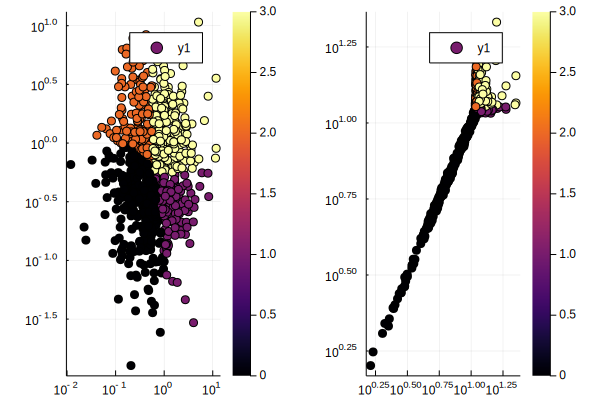

In [122]:
plot(scatter(A[1, :], A[2, :], zcolor = cols, scale = :log10),
     scatter(V[1, :], V[2, :], zcolor = cols, scale = :log10))

### Now save the data in a DataFrame

Construct an empty dataframe (take a look at the DataFrame documentation for an introduction) with all relevant columns.

In [132]:
df = DataFrame(
    a1_init = Float64[], a2_init = Float64[],
    r = Float64[], sigma = Float64[], tau = Float64[],
    Ms_12 = Float64[], Ms_21 = Float64[],
    Md_12 = Float64[], Md_21 = Float64[],
    d1 = Float64[], d2 = Float64[],
    sol1 = Bool[], sol2 = Bool[],
    val1 = Float64[], val2 = Float64[],
    a1 = Float64[], a2 = Float64[]
    )

,a1_init,a2_init,r,sigma,Ms_12,Ms_21,Md_12,Md_21,d1,d2,sol1,sol2,val1,val2,a1,a2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool,Bool,Float64,Float64,Float64,Float64


Now add the simulation results from above to the empty dataframe, by creating a DataFrame with the simulation results and appending it to the empty one.

In [133]:
append!(df, DataFrame(a1_init = a1_init*ones(nsim),a2_init = a2_init*ones(nsim),
                r = r*ones(nsim), sigma = σ*ones(nsim), tau = τ*ones(nsim),
                Ms_12 = Mˢ_12*ones(nsim), Ms_21 = Mˢ_21*ones(nsim),
                Md_12 = Mᵈ_12*ones(nsim), Md_21 = Mᵈ_21*ones(nsim),
                d1 = d1*ones(nsim), d2 = d2*ones(nsim),
                sol1 = sol[1, :], sol2 = sol[2, :],
                val1 = V[1, :], val2 = V[2, :],
                a1 = A[1, :], a2 = A[2, :]
                ))
;

Test what is in the dataframe now:

In [134]:
first(df, 10)

,a1_init,a2_init,r,sigma,Ms_12,Ms_21,Md_12,Md_21,d1,d2,sol1,sol2,val1,val2,a1,a2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool,Bool,Float64,Float64,Float64,Float64
1,1.0,1.0,0.0,1.0,0.0,0.0,0.95,0.95,11.3,11.3,true,false,12.3472,10.9291,1.96453,0.19411
2,1.0,1.0,0.0,1.0,0.0,0.0,0.95,0.95,11.3,11.3,true,true,16.4387,11.5869,5.70372,0.851883
3,1.0,1.0,0.0,1.0,0.0,0.0,0.95,0.95,11.3,11.3,false,false,11.0575,11.1778,0.438573,0.673191
4,1.0,1.0,0.0,1.0,0.0,0.0,0.95,0.95,11.3,11.3,true,false,11.6849,11.053,1.18459,0.317958
5,1.0,1.0,0.0,1.0,0.0,0.0,0.95,0.95,11.3,11.3,true,true,11.4481,12.6263,0.713056,1.89126
6,1.0,1.0,0.0,1.0,0.0,0.0,0.95,0.95,11.3,11.3,false,false,10.2396,10.2123,0.537896,0.484701
7,1.0,1.0,0.0,1.0,0.0,0.0,0.95,0.95,11.3,11.3,true,false,12.5485,10.7815,2.30615,0.0464679
8,1.0,1.0,0.0,1.0,0.0,0.0,0.95,0.95,11.3,11.3,true,true,11.6743,12.2662,0.939286,1.53121
9,1.0,1.0,0.0,1.0,0.0,0.0,0.95,0.95,11.3,11.3,false,true,10.8342,11.4605,0.0991683,1.16803


Save the dataframe as a csv file.

In [ ]:
output_path = "path/to/save/to/filename.csv"
CSV.write(output_path, df)

## Now vary one parameter

Vary one parameter, here r, while keeping the rest fixed.

In [3]:
# number of simulations to run per parameter setting
nsim = 750

# initialize r, τ, σ; in Julia to write Latex-like symbols, type \sigma and then press Tab
r_arr = collect(0.0:0.1:1.0)
τ = 1.0
σ = 1.0

# initial asset prices
a1_init = 1.0
a2_init = 1.0

# debt and equity cross holding parameters
Mˢ_12 = 0.0
Mˢ_21 = 0.0
Mᵈ_12 = 0.95
Mᵈ_21 = 0.95

# debt
d1 = 11.3
d2 = 11.3
; # this just supresses a print out at the end of the cell

In [4]:
df = DataFrame(
    a1_init = Float64[], a2_init = Float64[],
    r = Float64[], sigma = Float64[], tau = Float64[],
    Ms_12 = Float64[], Ms_21 = Float64[],
    Md_12 = Float64[], Md_21 = Float64[],
    d1 = Float64[], d2 = Float64[],
    sol1 = Bool[], sol2 = Bool[],
    val1 = Float64[], val2 = Float64[],
    a1 = Float64[], a2 = Float64[]
    );

In [5]:
a₀ = [a1_init, a2_init]
Mˢ = [0.0 Mˢ_12; Mˢ_21 0.0]
Mᵈ = [0.0 Mᵈ_12; Mᵈ_21 0.0]
d = [d1, d2]

for r in r_arr
    θ = BlackScholesParams(r, τ, σ)
    
    twoFirms = XOSModel(Mˢ, Mᵈ, I, d)
    
    Z = rand(MvNormal(2, 1.0), nsim)
    A = mapslices(z -> Aτ(a₀, θ, z), Z; dims = 1)
    X = mapslices(a -> fixvalue(twoFirms, a), A; dims = 1)
    sol = mapslices(x -> solvent(twoFirms, x), X; dims = 1)
    V = mapslices(x -> equityview(twoFirms, x) .+ debtview(twoFirms, x), X; dims = 1)

    append!(df, DataFrame(a1_init = a1_init*ones(nsim),a2_init = a2_init*ones(nsim),
                    r = r*ones(nsim), sigma = σ*ones(nsim), tau = τ*ones(nsim),
                    Ms_12 = Mˢ_12*ones(nsim), Ms_21 = Mˢ_21*ones(nsim),
                    Md_12 = Mᵈ_12*ones(nsim), Md_21 = Mᵈ_21*ones(nsim),
                    d1 = d1*ones(nsim), d2 = d2*ones(nsim),
                    sol1 = sol[1, :], sol2 = sol[2, :],
                    val1 = V[1, :], val2 = V[2, :],
                    a1 = A[1, :], a2 = A[2, :]
                    ))
end
;

Look at a specific subset.

In [65]:
df_r09 = @where(df, :r .== 0.9)
cols = df_r09[:sol1] .+ 2.0 .* df_r09[:sol2];

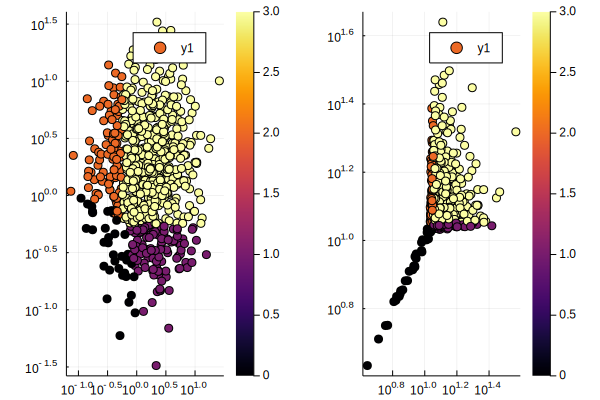

In [66]:
plot(scatter(df_r09[:a1], df_r09[:a2], zcolor = cols, scale = :log10),
     scatter(df_r09[:val1], df_r09[:val2], zcolor = cols, scale = :log10))

Example: compute correlation between values of banks given r was 0.9 and both banks have failed.

In [73]:
df2 = @where(df, :r.==0.9, :sol1.==false, :sol2.==false)
corr = cor(df2[:val1], df2[:val2])

0.9927675869533837

Using DataFrameMeta function by(), wich first groups by a set of columns. Plot the correlation of bank values colored by solvency.

In [75]:
corr_by_r_and_sol = by(df, [:r, :sol1, :sol2], [:val1, :val2] => x -> cor(x.val1, x.val2));
#last(corr_by_r_and_sol, 6)

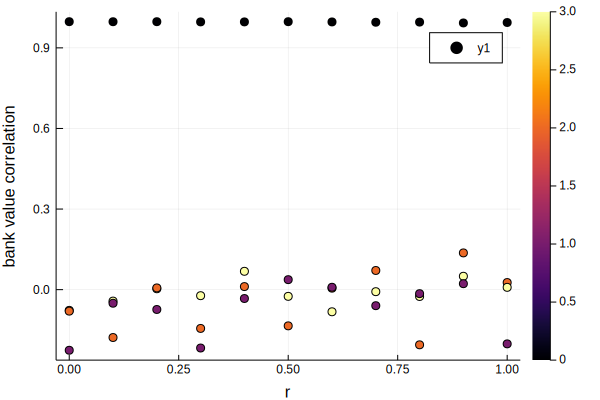

In [76]:
cols = corr_by_r_and_sol[:sol1] .+ 2.0 .* corr_by_r_and_sol[:sol2] ## Convert solvencies to different numbers
x = corr_by_r_and_sol[:r]
y = corr_by_r_and_sol[:x1]
scatter(x, y, zcolor = cols, xlabel="r", ylabel="bank value correlation")